In [1]:
from __future__ import print_function

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
#from keras.layers import Input, Dense, Lambda
#from keras.models import Model
#from keras import backend as K
#from keras import metrics
#from keras.datasets import mnist
#from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
#from keras.layers import Conv2DTranspose,Reshape
#import keras.layers as layers

from PIL import Image, ImageOps
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics

## Load the dataset

In [2]:
PATH = "./mergedConstellationsEasyStars2Outline_Large/"
checkpoint_path = "./training_ckpt/cp-{epoch:04d}.ckpt"
imageSaveDir = "./runVAE_Easy2Outline"
if not os.path.exists(imageSaveDir):
    os.makedirs(imageSaveDir)

In [3]:
%matplotlib inline

IMG_WIDTH = 256
IMG_HEIGHT = 256

batch_size = 256

original_dim = IMG_WIDTH*IMG_HEIGHT
latent_dim = 200
EPOCHS = epochs = 10
epsilon_std = 1.0

BUFFER_SIZE = 400

In [4]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    w = tf.shape(image)[1]

    w = w // 2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]
    print(type(real_image))

    input_image = tf.cast(input_image, np.float32)
    real_image = tf.cast(real_image, np.float32)

    return input_image, real_image

<class 'tensorflow.python.framework.ops.EagerTensor'>


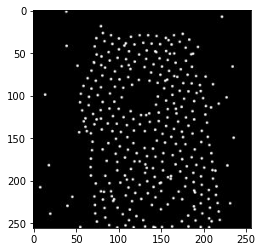

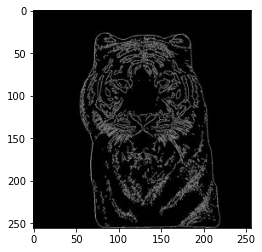

In [5]:
inp, re = load(PATH+'train/object_0_0.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(np.asarray(inp)/255.0)
plt.figure()
plt.imshow(np.asarray(re)/255.0)

In [6]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

In [7]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

In [8]:
@tf.function()
def random_jitter(input_image, real_image):
    # resizing to 286 x 286 x 3
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # randomly cropping to 256 x 256 x 3
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

In [9]:
# normalizing the images to [0, 1]

def normalize(input_image, real_image):
    input_image = input_image/255.0#(input_image / 127.5) - 1
    real_image = real_image/255.0#(real_image / 127.5) - 1

    return input_image, real_image

In [10]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [11]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

## Input Pipeline

In [12]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.map(load_image_train)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
<class 'tensorflow.python.framework.ops.Tensor'>
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When fil

In [13]:
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

<class 'tensorflow.python.framework.ops.Tensor'>


## Convert to numpy

In [14]:

train_np = np.stack(list(train_dataset))
test_np = np.stack(list(test_dataset))


In [15]:
noise_train = np.squeeze(train_np[:,0,:,:,:])
x_train = np.squeeze(train_np[:,1,:,:,:])

In [16]:
noise_test = np.squeeze(test_np[:,0,:,:,:])
x_test = np.squeeze(test_np[:,1,:,:,:])

In [17]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [18]:
#encoder part

x_noise = layers.Input(shape=(256, 256, 3,), name='input_layer')
    
# Block-1
x = layers.Conv2D(32, kernel_size=3, strides= 2, padding='same', name='conv_1')(x_noise)
x = layers.BatchNormalization(name='bn_1')(x)
x = layers.LeakyReLU(name='lrelu_1')(x)

# Block-2
x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
x = layers.BatchNormalization(name='bn_2')(x)
x = layers.LeakyReLU(name='lrelu_2')(x)

# Block-3
x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
x = layers.BatchNormalization(name='bn_3')(x)
x = layers.LeakyReLU(name='lrelu_3')(x)

# Block-4
x = layers.Conv2D(64, 3, 2, padding='same', name='conv_4')(x)
x = layers.BatchNormalization(name='bn_4')(x)
x = layers.LeakyReLU(name='lrelu_4')(x)

# Block-5
x = layers.Conv2D(64, 3, 2, padding='same', name='conv_5')(x)
x = layers.BatchNormalization(name='bn_5')(x)
x = layers.LeakyReLU(name='lrelu_5')(x)


# Final Block
flatten = layers.Flatten()(x)
z_mean = layers.Dense(200, name='mean')(flatten)
z_log_var = layers.Dense(200, name='log_var')(flatten)

#reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [19]:
#decoder part
# we instantiate these layers separately so as to reuse them later
z= layers.Reshape([1,1,latent_dim])(z)

x = layers.Dense(4096)(z)
x = layers.Reshape((8,8,64))(x)

# Block-1
x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# Block-2
x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# Block-3
x = layers.Conv2DTranspose(64, 3, 2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# Block-4
x = layers.Conv2DTranspose(32, 3, 2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)


# Block-5
x_out = layers.Conv2DTranspose(3, 3, 2,padding='same', activation='sigmoid')(x)
    

# instantiate VAE model
vae = Model(x_noise, x_out)
vae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 128, 128, 32) 896         input_layer[0][0]                
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 128, 128, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
lrelu_1 (LeakyReLU)             (None, 128, 128, 32) 0           bn_1[0][0]                       
______________________________________________________________________________________________

In [20]:
#from keras.utils.vis_utils import plot_model
#plot_model(vae, to_file='model1.png',show_shapes=True)

In [21]:
# Compute VAE loss
def VAE_loss(x_origin,x_out):
    x_origin=K.flatten(x_origin)
    x_out=K.flatten(x_out)
    xent_loss = original_dim * metrics.binary_crossentropy(x_origin, x_out)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss
vae.compile(optimizer='adam', loss=VAE_loss)

In [22]:
vae.fit(noise_train,x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(noise_test, x_test))

Train on 3455 samples, validate on 576 samples
Epoch 1/10
 256/3455 [=>............................] - ETA: 2:27 - loss: 47439.1094

KeyboardInterrupt: 

In [30]:
def generate_images_test(x_testImg, noise_testImg, x_outImg, saveFolder, index):
    
    inp = Image.fromarray((noise_testImg*255).astype(np.uint8))
    inp.save(f"{saveFolder}/input_{index}.jpg")
    
    tar = Image.fromarray((x_testImg*255).astype(np.uint8))
    tar.save(f"{saveFolder}/target_{index}.jpg")
    
    pred = Image.fromarray((x_outImg*255).astype(np.uint8))
    pred.save(f"{saveFolder}/predictions_{index}.jpg")
    


In [31]:
saveDir = PATH+"predictions_vae"
x_out=vae.predict(x_test)
for i in range(100):
    generate_images_test(x_test[i], noise_test[i], x_out[i], saveDir, i)